In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
np.set_printoptions(precision=3)
import sys
sys.path.append('../../zdrojaky')
from tsplot import tsplot

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Modelování časové řady COVID-19 pomocí SARIMA modelu

*Zdroj dat: https://onemocneni-aktualne.mzcr.cz/api/v3/docs*

Uvažujme opět datovou sadu poskytovanou MZ ČR:

In [2]:
fn = 'nakazeni-vyleceni-umrti-testy.csv'
data = pd.read_csv(fn, index_col=0, parse_dates=True, infer_datetime_format=True)
data.tail()

,kumulativni_pocet_nakazenych,kumulativni_pocet_vylecenych,kumulativni_pocet_umrti,kumulativni_pocet_testu,kumulativni_pocet_ag_testu,prirustkovy_pocet_nakazenych,prirustkovy_pocet_vylecenych,prirustkovy_pocet_umrti,prirustkovy_pocet_provedenych_testu,prirustkovy_pocet_provedenych_ag_testu,kumulativni_pocet_nove_nakazenych_primoinfekce,kumulativni_pocet_nove_nakazenych_reinfekce,prirustkovy_pocet_nove_nakazenych_primoinfekce,prirustkovy_pocet_nove_nakazenych_reinfekce
datum,,,,,,,,,,,,,,
2024-10-17,4803296,4749150,43666,22265090,35348868,875,1999,7,510,3538,4328967,474329,473,402
2024-10-18,4804052,4750476,43669,22265582,35351959,756,1326,3,492,3091,4329412,474640,445,311
2024-10-19,4804112,4751695,43674,22265665,35352163,60,1219,5,83,204,4329458,474654,46,14
2024-10-20,4804165,4752790,43675,22265762,35352400,53,1095,1,97,237,4329497,474668,39,14
2024-10-21,4805429,4753775,43678,22266375,35357890,1264,985,3,613,5490,4330182,475247,685,579


Zaměříme se na jeden ze sloupečků, v zásadě je jedno, jaký. Mají data nějaké význačné vlastnosti?

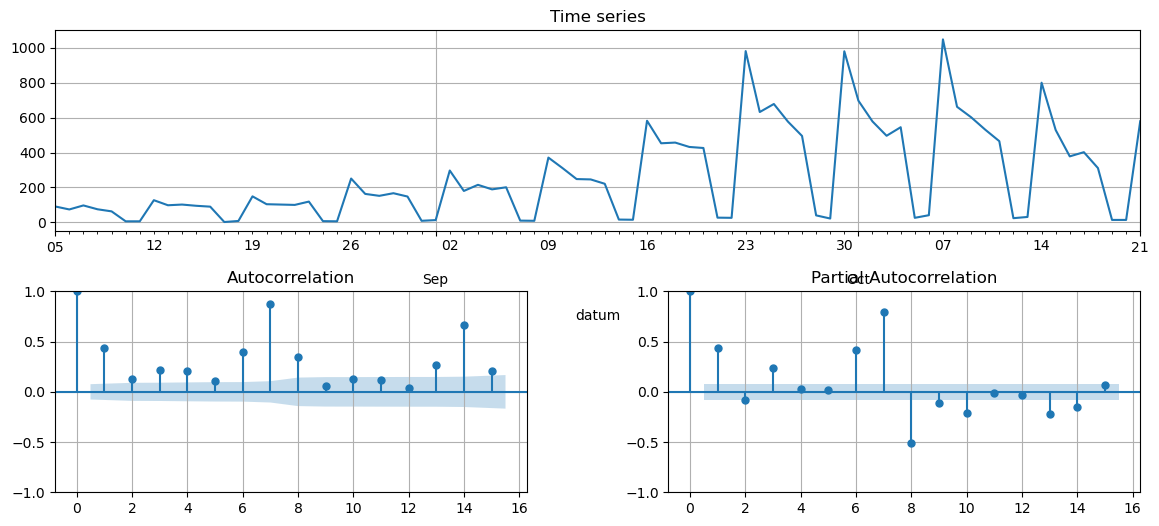

In [3]:
df_analysis = data['prirustkovy_pocet_nove_nakazenych_reinfekce'].last('12W')
df_analysis = df_analysis.asfreq('D')

tsplot(df_analysis, lags=15)

Zřejmě bychom mohli zkusit zapracovat na trendu v sezónních datech...

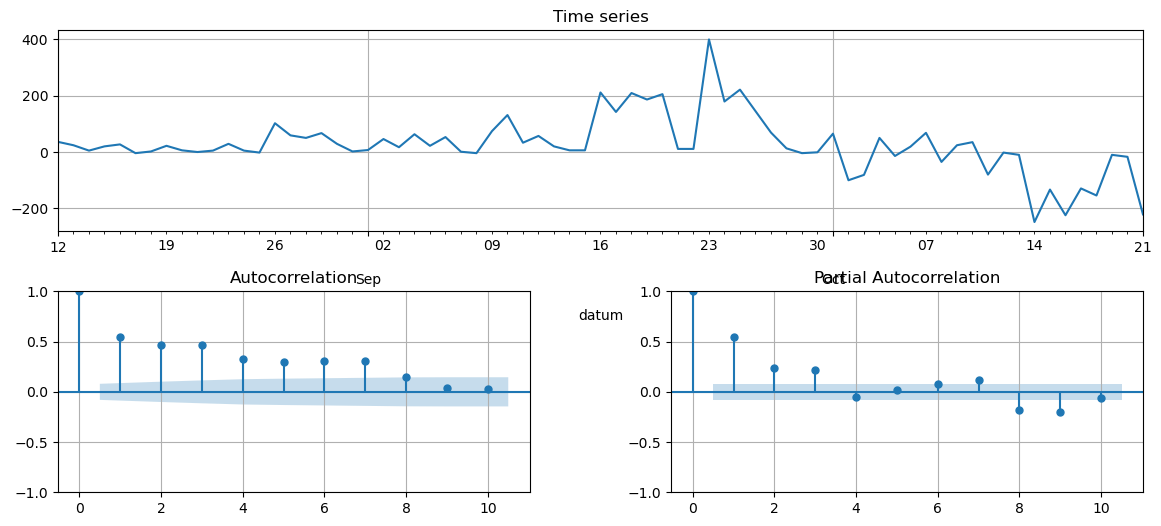

In [4]:
df_analysis_d7 = df_analysis.diff(7).dropna()
tsplot(df_analysis_d7, lags=10)

Podobně se

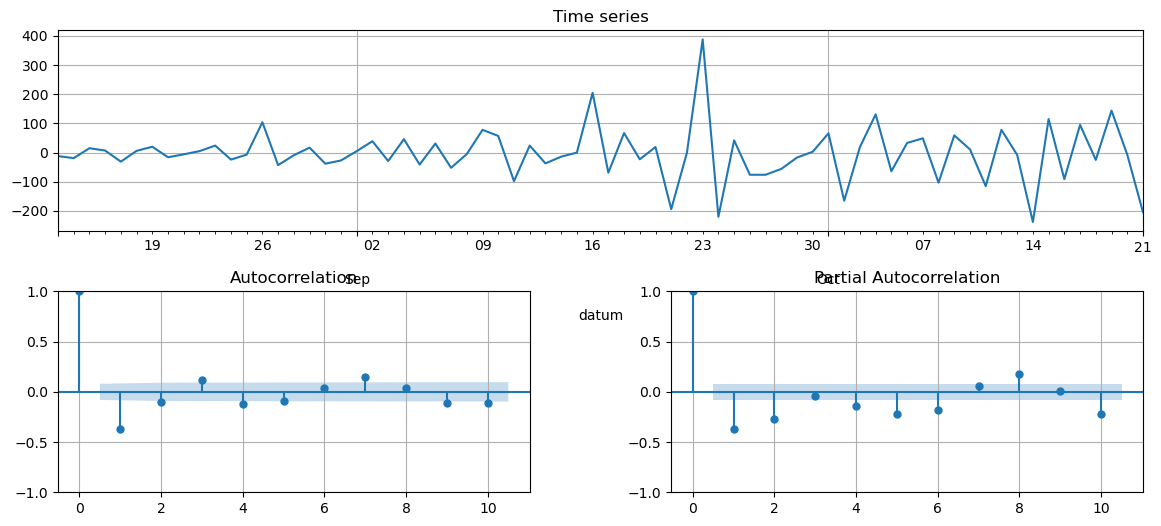

In [5]:
df_analysis_d7_d1 = df_analysis_d7.diff().dropna()
tsplot(df_analysis_d7_d1, lags=10)

Jakousi představu bychom měli, můžeme se podívat, jak bude korespondovat s automatizovaným odhadem řádů SARIMA modelu.

In [6]:
analysis_to_date = '2024-10-01'
df_analysis_full = df_analysis
df_analysis_train = df_analysis.loc[:analysis_to_date]

### Odhad řádů pomocí `pmdarima`

Odhad řádů (p,d,q) a (P,D,Q)s jde rovněž provádět pomocí [`pmdarima`](https://alkaline-ml.com/pmdarima/index.html), konkrétně metodou `auto_arima()`. Parametr `stepwise` umožňuje řídit, jak moc se bude hledání řádů "optimalizovat", či zda poběží na síti všech kombinací.

In [7]:
import pmdarima as pm
stepwise_fit = pm.auto_arima(df_analysis_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, trace=True, stepwise=False,
                             information_criterion='bic')

 ARIMA(0,1,0)(0,1,0)[7]             : BIC=589.857, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[7]             : BIC=589.874, Time=0.02 sec
 ARIMA(0,1,0)(0,1,2)[7]             : BIC=593.628, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[7]             : BIC=589.520, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[7]             : BIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(1,1,2)[7]             : BIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(2,1,0)[7]             : BIC=593.098, Time=0.05 sec
 ARIMA(0,1,0)(2,1,1)[7]             : BIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(2,1,2)[7]             : BIC=inf, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[7]             : BIC=581.490, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[7]             : BIC=579.998, Time=0.06 sec
 ARIMA(0,1,1)(0,1,2)[7]             : BIC=583.340, Time=0.10 sec
 ARIMA(0,1,1)(1,1,0)[7]             : BIC=579.104, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[7]             : BIC=581.374, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[7]             : BIC=585.283, Time=0.34 sec
 ARIMA(0,1,1)(2,1,0)[7]             : BIC

Automatickým nástrojem máme vybraný nejlepší model. Ten můžeme následně nafitovat pomocí `ARIMA()`. `pmdarima` umožňuje pokračovat s ní, ale pro přímočarost zůstaňme u `statsmodels`:

In [8]:
model = ARIMA(df_analysis_train, order=(0,1,1), seasonal_order=(1,1,0,7), trend='n')
res = model.fit()
print(res.summary())

                                            SARIMAX Results                                            
Dep. Variable:     prirustkovy_pocet_nove_nakazenych_reinfekce   No. Observations:                   58
Model:                            ARIMA(0, 1, 1)x(1, 1, [], 7)   Log Likelihood                -283.684
Date:                                         Tue, 22 Oct 2024   AIC                            573.368
Time:                                                 16:34:49   BIC                            579.104
Sample:                                             08-05-2024   HQIC                           575.553
                                                  - 10-01-2024                                         
Covariance Type:                                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1     

Sami interpretujte výsledky! Ty výše, ale i ty níže...

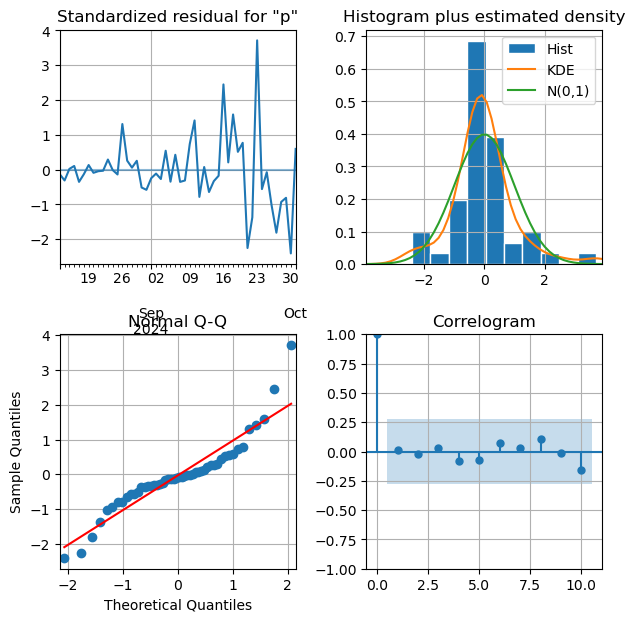

In [9]:
res.plot_diagnostics(figsize=(7,7))
plt.show()

In [10]:
preds_to_date = '2024-11-01'
preds = res.get_prediction(end=preds_to_date)
preds.summary_frame().tail()

prirustkovy_pocet_nove_nakazenych_reinfekce,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-10-28,856.656813,539.637654,-201.013554,1914.327180
2024-10-29,608.776972,558.910622,-486.667718,1704.221661
2024-10-30,638.736104,613.096887,-562.911714,1840.383922
2024-10-31,496.891089,641.051963,-759.547669,1753.329848
2024-11-01,374.046075,667.837888,-934.892132,1682.984283


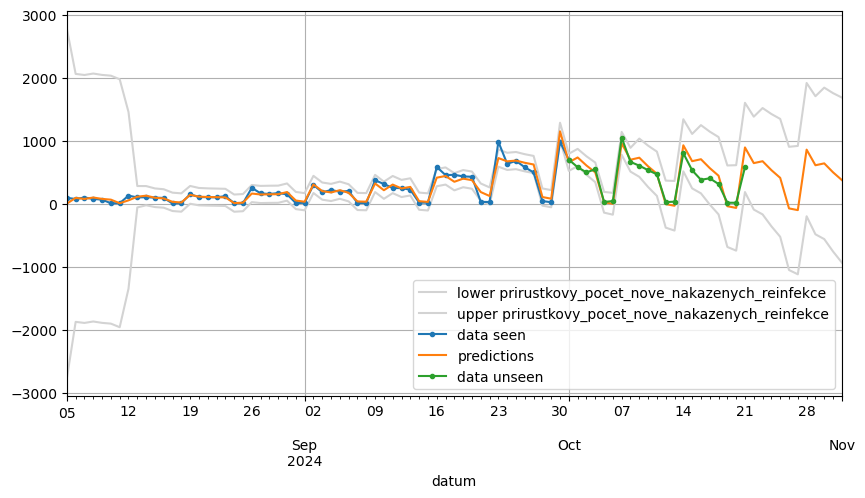

In [11]:
ci = preds.conf_int()

fig = ci.plot(color='lightgrey', figsize=(10, 5))
res.data.orig_endog.plot(label='data seen', marker='.', fig=fig)
preds.predicted_mean.plot(label='predictions', fig=fig)
df_analysis_full.loc[analysis_to_date:].plot(label='data unseen', marker='.', fig=fig)
plt.legend()
plt.show()

Zamyslete se, co by se dalo na modelu vylepšovat a jak by se dalo dále postupovat.